# <font color=red>Fundamental 12 . 이미지 파일 다루기</font>

##  1. Pillow 라이브러리 (PIL)

`PIL.Image.fromarray()` 를 통해 이미지 객체로 변환

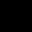

In [1]:
import numpy as np
from PIL import Image

data = np.zeros([32, 32, 3], dtype=np.uint8)
image = Image.fromarray(data, 'RGB')
image     # 다른 개발 환경에서는 .show() 메서드 활용

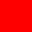

In [2]:
data[:, :] = [255, 0, 0]      # RGB 값
image = Image.fromarray(data, 'RGB')
image

----
`PIL.Image.open` 을 통해 이미지 불러오기

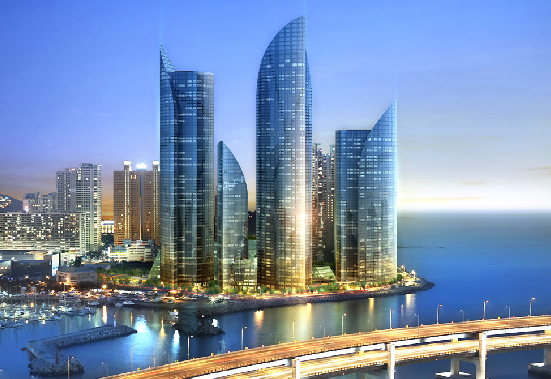

In [3]:
from PIL import Image
import os

# 연습용 파일 경로
image_path = os.getenv('HOME')+'/aiffel/python_image_proc/data/haeundae.png'

# 이미지 열기
img = Image.open(image_path)
img

In [4]:
# width와 height 출력
print(f'가로 : {img.width}')
print(f'세로 : {img.height}')

# JPG 파일 형식으로 저장
new_image_path = os.getenv('HOME')+'/aiffel/python_image_proc/data/jpg_haeundae.jpg'
img = img.convert('RGB')
img.save(new_image_path)

가로 : 551
세로 : 379


----  

`resize()` 을 통해 이미지의 크기를 변환  

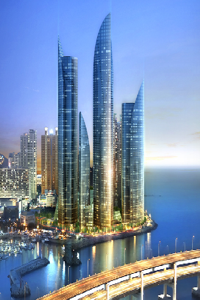

In [5]:
resized_image = img.resize((200,300))
resized_image

----
`crop()` 을 통해 이미지의 한 부분만 잘라냄  

예시로 사진에서 아파트 1개의 부분만 잘라내보자.

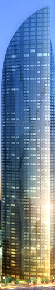

In [6]:
box = (255,10,310,300)    # 좌표 설정
cropped_image = img.crop(box)
cropped_image

----
### CIFAR-100 데이터를 받아 개별 이미지 파일로 추출하기

In [7]:
import os
import pickle
from PIL import Image

dir_path = os.getenv('HOME')+'/aiffel/python_image_proc/data/cifar-100-python'
train_file_path = os.path.join(dir_path, 'train')

with open(train_file_path, 'rb') as f:
    train = pickle.load(f, encoding='bytes')

print(type(train))

<class 'dict'>


In [8]:
train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [9]:
type(train[b'filenames'])

list

In [10]:
train[b'filenames'][0:5]

[b'bos_taurus_s_000507.png',
 b'stegosaurus_s_000125.png',
 b'mcintosh_s_000643.png',
 b'altar_boy_s_001435.png',
 b'cichlid_s_000031.png']

딕셔너리의 `b'data'` 부분을 보자.

In [11]:
train[b'data'][0:5]

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       [124, 131, 135, ..., 232, 236, 231],
       [ 43,  32,  87, ...,  60,  29,  37]], dtype=uint8)

In [12]:
train[b'data'][0].shape

(3072,)

32x32(이미지크기) x 3(채널수, RGB) = 3072 이므로 각 화소에 해당하는 이미지임을 알 수 있다.  
(3072, ) 데이터 shape 을 (32,32,3) 으로 reshape 후 출력  

앞선 차원부터 데이터를 채우는 방식의 reshape 방식위해 __order값을  F 로 지정__

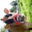

In [13]:
image_data = train[b'data'][0].reshape([32, 32, 3], order='F')   # order를 주의
image = Image.fromarray(image_data)    # Pillow를 사용하여 Numpy 배열을 Image객체로 만들어서
image   

`np.swapaxes(0,1)` 을 이용하여 데이터 x축 y축 바꾸기

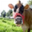

In [14]:
image_data = image_data.swapaxes(0, 1)
image = Image.fromarray(image_data)
image

이제 전체 CIFAR-100 데이터에 대한 이미지를 불러와 저장하자.

In [15]:
import os
import pickle
from PIL import Image
import numpy
from tqdm import tqdm

dir_path = os.getenv('HOME')+'/aiffel/python_image_proc/data/cifar-100-python'
train_file_path = os.path.join(dir_path, 'train')

# image를 저장할 cifar-100-python의 하위 디렉토리(images)를 생성
images_dir_path = os.getenv('HOME')+'/aiffel/python_image_proc/cifar-images'
if not os.path.exists(images_dir_path):
    os.mkdir(images_dir_path)  # images 디렉토리 생성

# 32X32의 이미지 파일 50000개를 생성
with open(train_file_path, 'rb') as f:
    train = pickle.load(f, encoding='bytes')
    for i in tqdm(range(len(train[b'filenames']))):
        filename = train[b'filenames'][i].decode()
        data = train[b'data'][i].reshape([32, 32, 3], order='F')
        image = Image.fromarray(data.swapaxes(0, 1))
        image.save(os.path.join(images_dir_path, filename))

100%|██████████| 50000/50000 [01:32<00:00, 542.48it/s]


----

# OpenCV
컴퓨터 비전 용 라이브러리  
영상 처리에 대한 다양한 기능 구현 가능  
[OpenCV-Python Tutorials](https://docs.opencv.org/master/d6/d00/tutorial_py_root.html) 페이지에서 여러 고급 기능에 대한 예제들이 설명 되어있다.

### 이미지에서 특정 색 영역 추출
여러 기능들 중 이번에는 이미지에서 특정 색을 가진 영역만 추출해보겠다.  
참고 튜토리얼 사이트 > [Changing Colorspaces](https://docs.opencv.org/master/df/d9d/tutorial_py_colorspaces.html)  

앞에서 이용한 해운대 이미지에서 파란색에 해당하는 부분만 추출해보자.

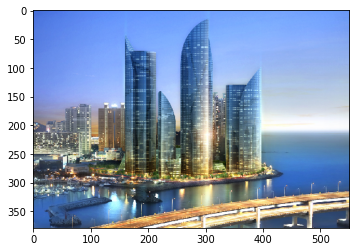

In [3]:
import os
import cv2 as cv
import numpy as np
from  matplotlib import pyplot as plt
%matplotlib inline

img_path = os.getenv('HOME')+'/aiffel/python_image_proc/data/haeundae.png'
img = cv.imread(img_path)

# Convert BGR to HSV
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

# define range of blue color in HSV
lower_blue = np.array([100,100,100])
upper_blue = np.array([130,255,255])

# Threshold the HSV image to get only blue colors
mask = cv.inRange(hsv, lower_blue, upper_blue)

# Bitwise-AND mask and original image
res = cv.bitwise_and(img,img, mask= mask)

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))   
plt.show()

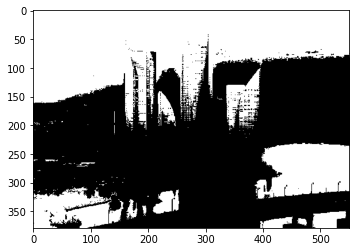

In [4]:
plt.imshow(cv.cvtColor(mask, cv.COLOR_BGR2RGB))
plt.show()

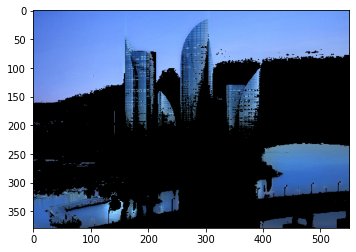

In [5]:
plt.imshow(cv.cvtColor(res, cv.COLOR_BGR2RGB))
plt.show()

### 이미지에서 색상 히스토그램 추출 후 서로 비교

OpenCV 에서 제공하는 기능 중에서 이미지에서 색상 히스토그램 추출 후 서로 비교하는 기능을 이용하여 CIFAR-100 이미지 중 비슷한 이미지를 찾아내보자.

In [19]:
import os
import pickle
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image

# 전처리 시 생성했던 디렉토리 구조
dir_path = os.getenv('HOME')+'/aiffel/python_image_proc/'
train_file_path = os.path.join(dir_path, 'train')
images_dir_path = os.path.join(dir_path, 'cifar-images')

파일명을 인자로 받아 해당 파일과 히스토그램을 출력하는 함수를 만들자.

In [20]:
def draw_color_histogram_from_image(file_name):
    image_path = os.path.join(images_dir_path, file_name)
    # 이미지 열기
    img = Image.open(image_path)
    cv_image = cv2.imread(image_path)

    # Image와 Histogram 그리기
    f=plt.figure(figsize=(10,3))
    im1 = f.add_subplot(1,2,1)
    im1.imshow(img)
    im1.set_title("Image")

    im2 = f.add_subplot(1,2,2)
    color = ('b','g','r')
    for i,col in enumerate(color):
        # image에서 i번째 채널의 히스토그램을 뽑아서(0:blue, 1:green, 2:red)
        histr = cv2.calcHist([cv_image],[i],None,[256],[0,256])   
        im2.plot(histr,color = col)   # 그래프를 그릴 때 채널 색상과 맞춰서 그림
    im2.set_title("Histogram")

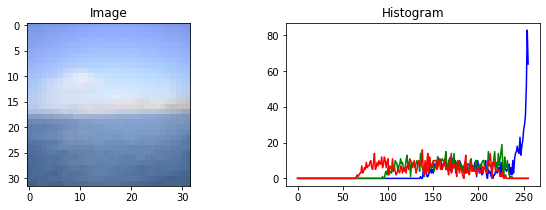

In [21]:
draw_color_histogram_from_image('adriatic_s_001807.png')

이제 본격적으로 CIFAR-100 이미지 중 가장 비슷한 개의 이미지를 찾는 기능의 알고리즘을 만들어보자.

In [22]:
def get_histogram(image):    # 이미지 1개에 대해 히스토그램을 만드는 함수
    histogram = []

    # Create histograms per channels, in 4 bins each.
    for i in range(3):
        channel_histogram = cv2.calcHist(images=[image],
                                         channels=[i],
                                         mask=None,
                                         histSize=[4],   # 히스토그램 구간을 4개로 설정
                                         ranges=[0, 256])
        histogram.append(channel_histogram)  
    histogram = np.concatenate(histogram)
    histogram = cv2.normalize(histogram, histogram)

    return histogram

In [24]:
def build_histogram_db():
    histogram_db = {}

    #디렉토리에 모아 둔 이미지 파일들을 전부 리스트업합니다. 
    path = images_dir_path
    file_list = os.listdir(images_dir_path)

    for file_name in tqdm(file_list):
        file_path = os.path.join(images_dir_path, file_name)
        image = cv2.imread(file_path)

        histogram = get_histogram(image)

        histogram_db[file_name] = histogram

    return histogram_db

In [25]:
histogram_db = build_histogram_db()
histogram_db['adriatic_s_001807.png']

100%|██████████| 49999/49999 [00:07<00:00, 6886.17it/s]


array([[0.        ],
       [0.        ],
       [0.29744893],
       [0.5828624 ],
       [0.        ],
       [0.17107612],
       [0.41608465],
       [0.29315054],
       [0.        ],
       [0.34301192],
       [0.37224102],
       [0.16505837]], dtype=float32)

입력받은 이미지의 히스토그램을 저장하는 함수 `get_target_histogram` 정의

In [26]:
def get_target_histogram():
    filename = input("이미지 파일명을 입력하세요: ")
    if filename not in histogram_db:
        print('유효하지 않은 이미지 파일명입니다.')
        return None
    return histogram_db[filename]

In [28]:
target_histogram = get_target_histogram()
target_histogram

이미지 파일명을 입력하세요: adriatic_s_001807.png


array([[0.        ],
       [0.        ],
       [0.29744893],
       [0.5828624 ],
       [0.        ],
       [0.17107612],
       [0.41608465],
       [0.29315054],
       [0.        ],
       [0.34301192],
       [0.37224102],
       [0.16505837]], dtype=float32)

`search` : n개의 비슷한 데이터를 찾는 함수 정의(기본값은 5개로 지정)

In [29]:
def search(histogram_db, target_histogram, top_k=5):
    results = {}

    # Calculate similarity distance by comparing histograms.
    for file_name, histogram in tqdm(histogram_db.items()):
        distance = cv2.compareHist(H1=target_histogram,
                                   H2=histogram,
                                   method=cv2.HISTCMP_CHISQR)

        results[file_name] = distance

    results = dict(sorted(results.items(), key=lambda item: item[1])[:top_k])

    return results

In [30]:
result = search(histogram_db, target_histogram)
result

100%|██████████| 49999/49999 [00:00<00:00, 601349.47it/s]


{'adriatic_s_001807.png': 0.0,
 'baby_s_001654.png': 0.047506706444185816,
 'fogbank_s_000423.png': 0.059270738493642845,
 'tank_s_000442.png': 0.060966690827361725,
 'dessert_plate_s_000124.png': 0.06113711905561663}

`show_result` : 찾은 5개의 데이터를 이미지로 출력하는 함수 정의

In [31]:
def show_result(result):
    f=plt.figure(figsize=(10,3))
    for idx, filename in enumerate(result.keys()):    
        img_path = os.path.join(images_dir_path, filename)
        im = f.add_subplot(1,len(result),idx+1)
        img = Image.open(img_path)
        im.imshow(img)

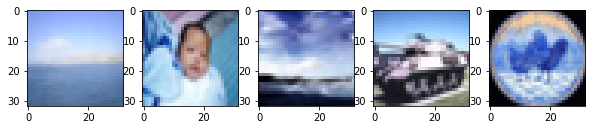

In [32]:
show_result(result)

처음 이미지가 입력값으로 넣은 이미지이고, 이것을 포함하여 비슷한 이미지 5개를 찾았다.

최종으로 프로그램을 실행시키고 싶을 때 실행해야하는 코드는 아래와 같다.  

검색할 이미지(이미지 파일명)를 입력값으로 받고 그와 비슷한 이미지 5개를 출력한다.

예시로, 입력값에는 leopard_s_001047.png 를 입력했다.

이미지 파일명을 입력하세요: leopard_s_001047.png


100%|██████████| 49999/49999 [00:00<00:00, 636081.57it/s]


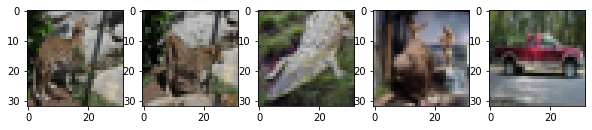

In [35]:
target_histogram = get_target_histogram()
result = search(histogram_db, target_histogram)
show_result(result)